In [98]:
%matplotlib inline
import os
import numpy as np
from datetime import datetime, timedelta
import metpy.calc as mcalc
from metpy.units import units
import matplotlib.dates as mpdates
import matplotlib.pyplot as plt
import requests
import time

In [7]:
# create array of days to loop through
dt0 = datetime(2016, 8, 1)
dt1 = datetime(2020, 7, 1)
num_days = int((dt1 - dt0).total_seconds()/86400.)
date_list = [dt0 + timedelta(days=ii) for ii in range(num_days)]

In [117]:
# define empty lists for data collection
RELH, TAIR, WSPD, WDIR, dt_all = ([] for _ in range(5))
base_URL = "http://www.mesonet.org/index.php/dataMdfMts/dataController/getFile/"
for i, d in enumerate(date_list):
    yr = d.year
    mo = d.month
    da = d.day
    if da == 1:
        print(d)
    # construct url for mts file
    mts_URL = f"{base_URL}{yr:04d}{mo:02d}{da:02d}nrmn/mts/TEXT/"
    # create request
    r = requests.get(mts_URL)
    while r.status_code != 200:
        r = requests.get(mts_URL)
        time.sleep(0.1)
    txt = r.text
    r.close()
    # parse data
    txt = txt.split("\n")
    # data start on line index 3
    for ii in range(3, len(txt)-1):
        txt_line = txt[ii].split()
        RELH.append(float(txt_line[3]))
        TAIR.append(float(txt_line[4]))
        WSPD.append(float(txt_line[5]))
        WDIR.append(float(txt_line[7]))
        dt_all.append(d + timedelta(minutes=float(txt_line[2])))
print("Done")

2016-08-01 00:00:00
2016-09-01 00:00:00
2016-10-01 00:00:00
2016-11-01 00:00:00
2016-12-01 00:00:00
2017-01-01 00:00:00
2017-02-01 00:00:00
2017-03-01 00:00:00
2017-04-01 00:00:00
2017-05-01 00:00:00
2017-06-01 00:00:00
2017-07-01 00:00:00
2017-08-01 00:00:00
2017-09-01 00:00:00
2017-10-01 00:00:00
2017-11-01 00:00:00
2017-12-01 00:00:00
2018-01-01 00:00:00
2018-02-01 00:00:00
2018-03-01 00:00:00
2018-04-01 00:00:00
2018-05-01 00:00:00
2018-06-01 00:00:00
2018-07-01 00:00:00
2018-08-01 00:00:00
2018-09-01 00:00:00
2018-10-01 00:00:00
2018-11-01 00:00:00
2018-12-01 00:00:00
2019-01-01 00:00:00
2019-02-01 00:00:00
2019-03-01 00:00:00
2019-04-01 00:00:00
2019-05-01 00:00:00
2019-06-01 00:00:00
2019-07-01 00:00:00
2019-08-01 00:00:00
2019-09-01 00:00:00
2019-10-01 00:00:00
2019-11-01 00:00:00
2019-12-01 00:00:00
2020-01-01 00:00:00
2020-02-01 00:00:00
2020-03-01 00:00:00
2020-04-01 00:00:00
2020-05-01 00:00:00
2020-06-01 00:00:00
Done


In [118]:
# convert to np arrays
RELH = np.array(RELH)
TAIR = np.array(TAIR)
WSPD = np.array(WSPD)
WDIR = np.array(WDIR)
# remove bad data
RELH[RELH < -100.] = np.nan
TAIR[TAIR < -100.] = np.nan
WSPD[WSPD < -100.] = np.nan
WDIR[WDIR < -100.] = np.nan

In [119]:
# convert T/RH to Td
TDEW = mcalc.dewpoint_rh(TAIR * units.degC, RELH/100. * units.dimensionless).to('degF').magnitude

/Users/briangreene/anaconda3/lib/python3.7/site-packages/pint/quantity.py:1175: RuntimeWarning: invalid value encountered in greater
  return op(self._convert_magnitude_not_inplace(UnitsContainer()), other)


In [120]:
np.nanmax(TDEW)

78.50444466290926

In [121]:
np.nanmin(TDEW)

-9.18533996398837

In [139]:
# interpolate to get rid of nans
i_use = ~np.isnan(TAIR)
# define relative time array - seconds since dt0
t_rel = np.array([(it - dt0).total_seconds() for it in dt_all])
TAIR_int = np.interp(t_rel, t_rel[i_use], TAIR[i_use])

In [182]:
# calculate autocorrelation
R_TAIR = np.correlate(TAIR_int, TAIR_int, mode='full')
# normalize
imax = int((len(R_TAIR)-1)/2)
R_TAIR /= R_TAIR[imax]

In [174]:
lags_days = np.linspace(-len(TAIR_int), len(TAIR_int), 2*len(TAIR_int)-1) * 5. / 1440.

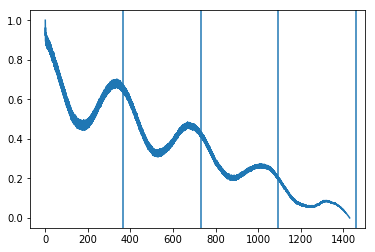

In [187]:
plt.plot(lags_days[imax:], R_TAIR[imax:])
plt.axvline(365)
plt.axvline(365*2)
plt.axvline(365*3)
plt.axvline(365*4)

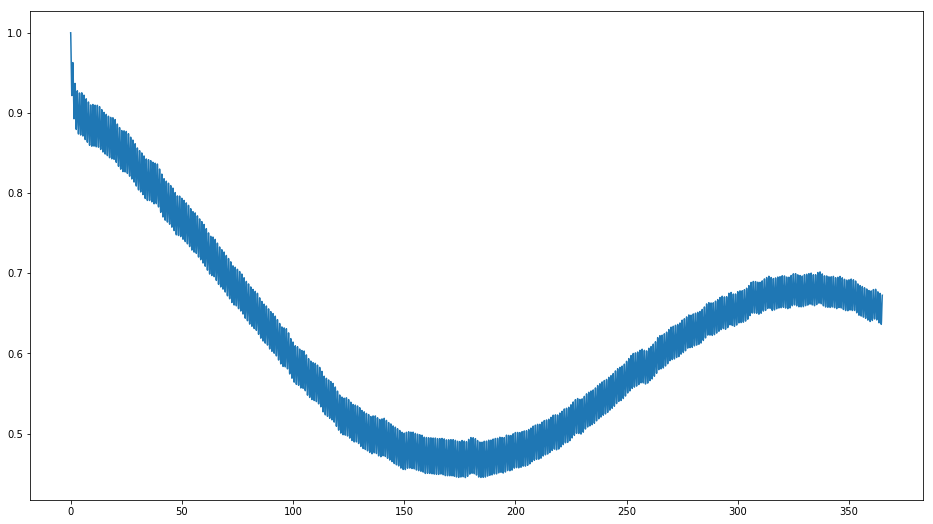

In [191]:
# just look at 1 year
iyr = np.where(lags_days >= 365.)[0][0]
plt.figure(figsize=(16,9))
plt.plot(lags_days[imax:iyr], R_TAIR[imax:iyr])

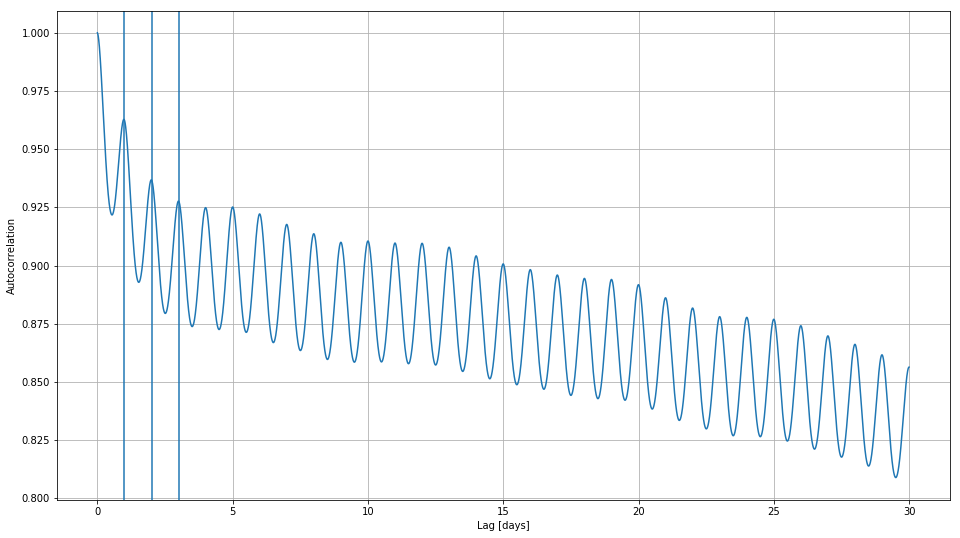

In [195]:
# just look at 1 month
imo = np.where(lags_days >= 30.)[0][0]
plt.figure(figsize=(16,9))
plt.plot(lags_days[imax:imo], R_TAIR[imax:imo])
plt.axvline(1)
plt.axvline(2)
plt.axvline(3)
plt.xlabel('Lag [days]')
plt.ylabel('Autocorrelation')
plt.grid()